# Create/Update Stitched Streams
## Inputs: roll schedule, raw maturities, [PRICE] & [CARRY] streams
If no PRICE and CARRY streams then initialize
If there is a PRICE and CARRY stream, then update using roll schedule and raw maturities


In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Class allows dispaly of objects
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

In [4]:
# Test Data...
'''
df1 = pd.DataFrame(np.random.rand(30,1) * 10 + 5, index=(pd.date_range("4th of July, 2015", periods=30)))
df2 = pd.DataFrame(np.random.rand(45,1) * 10 + 15, index=(pd.date_range("4th of July, 2015", periods=45)))
df3 = pd.DataFrame(np.random.rand(45,1) * 10 + 30, index=(pd.date_range("15th of July, 2015", periods=45)))
'''
df1 = pd.DataFrame((np.arange(1,51,1)).reshape(50,1) , index=(pd.date_range("4th of July, 2015", periods=50)))
df2 = pd.DataFrame((np.arange(10,510,10)).reshape(50,1) , index=(pd.date_range("4th of July, 2015", periods=50)))
df3 = pd.DataFrame((np.arange(100,5100,100)).reshape(50,1) , index=(pd.date_range("4th of July, 2015", periods=50)))
df4 = pd.DataFrame((np.arange(1000,51000,1000)).reshape(50,1) , index=(pd.date_range("4th of July, 2015", periods=50)))
display('df1.head()', 'df2.head()', 'df3.head()', 'df4.head()')
display('df1.tail()', 'df2.tail()', 'df3.tail()', 'df4.tail()')

'\ndf1 = pd.DataFrame(np.random.rand(30,1) * 10 + 5, index=(pd.date_range("4th of July, 2015", periods=30)))\ndf2 = pd.DataFrame(np.random.rand(45,1) * 10 + 15, index=(pd.date_range("4th of July, 2015", periods=45)))\ndf3 = pd.DataFrame(np.random.rand(45,1) * 10 + 30, index=(pd.date_range("15th of July, 2015", periods=45)))\n'

,0
2015-07-04,1
2015-07-05,2
2015-07-06,3
2015-07-07,4
2015-07-08,5
,0
2015-07-04,10
2015-07-05,20
2015-07-06,30
2015-07-07,40


,0
2015-08-18,46
2015-08-19,47
2015-08-20,48
2015-08-21,49
2015-08-22,50
,0
2015-08-18,460
2015-08-19,470
2015-08-20,480
2015-08-21,490


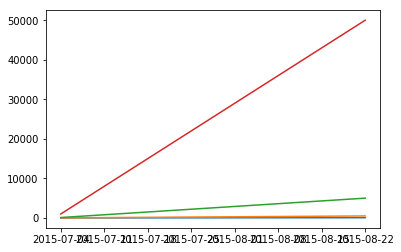

In [5]:
plt.plot(df1)
plt.plot(df2)
plt.plot(df3)
plt.plot(df4)

In [42]:
schedule = [{'DATETIME': pd.to_datetime('20150706'), 'CARRY_CONTRACT': 'df2', 'PRICE_CONTRACT': 'df1' },
               {'DATETIME': pd.to_datetime('20150717'), 'CARRY_CONTRACT': 'df3', 'PRICE_CONTRACT': 'df2'},
               {'DATETIME': pd.to_datetime('20150812'), 'CARRY_CONTRACT': 'df4', 'PRICE_CONTRACT': 'df3'}]
df_schedule = pd.DataFrame(schedule)
df_schedule.set_index('DATETIME', inplace=True)
df_schedule

,CARRY_CONTRACT,PRICE_CONTRACT
DATETIME,,
2015-07-06,df2,df1
2015-07-17,df3,df2
2015-08-12,df4,df3


In [75]:
# Create the PANAMA-stitched PRICE stream
for index, row in enumerate(df_schedule.itertuples()):
    if index == 0:
        df_new = eval(df_schedule.loc[row.Index]['PRICE_CONTRACT'])
        df_new.columns = ['PRICE']
        df_panprice = df_new.loc[row.Index:]
    else:
        df_expiring = eval(df_schedule.iloc[index-1]['PRICE_CONTRACT'])
        df_expiring.columns = ['PRICE']
        df_new = eval(df_schedule.iloc[index]['PRICE_CONTRACT'])
        df_new.columns = ['PRICE']
        delta = df_new.loc[row.Index]['PRICE'] - df_expiring.loc[row.Index]['PRICE']
        df_panprice = pd.concat([(df_panprice + delta)[:row.Index][:-1], df_new[row.Index:]])
"Header"               
df_panprice.head()
"Tail"
df_panprice.tail()
        

'Header'

,PRICE
2015-07-06,3729
2015-07-07,3730
2015-07-08,3731
2015-07-09,3732
2015-07-10,3733


'Tail'

,PRICE
2015-08-18,4600
2015-08-19,4700
2015-08-20,4800
2015-08-21,4900
2015-08-22,5000


In [62]:
df_schedule

,CARRY_CONTRACT,PRICE_CONTRACT
DATETIME,,
2015-07-06,df2,df1
2015-07-17,df3,df2
2015-08-12,df4,df3


In [76]:
#Creating the CARRY stream ... concatenating successive streams
        
for index, row in enumerate(df_schedule.itertuples()):
    temp_price = eval(df_schedule.loc[row.Index]['PRICE_CONTRACT']).loc[row.Index:]
    last_price = temp_price.index[-1]
    temp_carry = eval(df_schedule.loc[row.Index]['CARRY_CONTRACT']).loc[row.Index:last_price]
    if index == 0:
        df_carry = pd.concat([temp_price, temp_carry], axis=1)
        df_carry.columns = ['PRICE','CARRY']
        df_carry['CARRY_CONTRACT'] = df_schedule.iloc[index]['CARRY_CONTRACT']
        df_carry['PRICE_CONTRACT'] = df_schedule.iloc[index]['PRICE_CONTRACT']
    else:
        df_toappend = pd.concat([temp_price, temp_carry], axis=1)
        df_toappend.columns = ['PRICE','CARRY']
        df_toappend['CARRY_CONTRACT'] = df_schedule.iloc[index]['CARRY_CONTRACT']
        df_toappend['PRICE_CONTRACT'] = df_schedule.iloc[index]['PRICE_CONTRACT']
        df_carry = pd.concat([df_carry.loc[:row.Index][:-1], df_toappend])
"Header"
df_carry.head()
"Tail"
df_carry.tail()

,PRICE,CARRY,CARRY_CONTRACT,PRICE_CONTRACT
2015-07-06,3,30,df2,df1
2015-07-07,4,40,df2,df1
2015-07-08,5,50,df2,df1
2015-07-09,6,60,df2,df1
2015-07-10,7,70,df2,df1


,PRICE,CARRY,CARRY_CONTRACT,PRICE_CONTRACT
2015-08-18,4600,46000,df4,df3
2015-08-19,4700,47000,df4,df3
2015-08-20,4800,48000,df4,df3
2015-08-21,4900,49000,df4,df3
2015-08-22,5000,50000,df4,df3
